In [1]:
"""
Simple tester for the vgg19_trainable
"""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

#import vgg16_new as vgg16

import vgg16_seed as vgg16

import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv

PRETRAINED_MODEL_PATH=None # "/home/sik4hi/ckpt_dir"
N_EPOCHS = 1
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 90
N_CLASSES = 1000
DROPOUT = 0.50
ckpt_dir = "/mnt/data1/imagenet-data/ckpt_dir"
#LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
#TRAINSET_PATH = '/mnt/data1/imagenet-data/csv-files/train2/imagenetdataall0.csv'
#VALSET_PATH ='/mnt/data1/imagenet-data/csv-files/val/imagenetorigval.csv'
#VALSET_PATH ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata0.csv'
#VALSET_PATH ='/mnt/data1/Related_Dataset/Related_csv/val_related_image_fine_lables.csv'
#VALSET_PATH ='/mnt/data1/Related_Dataset/Related_csv/val_related_image_fine_lables.csv'
#VALSET_PATH ="/mnt/data1/unrelated_dataset/unrelated_csv/val_unrelated_image_labels.csv"
VALSET_PATH = "/mnt/data1/Related_Dataset/Related_csv/val_related_image_coarse_lables.csv"

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#=======================================================================================================
# Reading Training data from CSV FILE
#=======================================================================================================
    
val_csv_file=open(VALSET_PATH,"r")
val_filepaths=[]
val_labels=[]
for line in val_csv_file:
    filepath, label= line.split(",")
    label= int(label)
    val_filepaths.append(filepath)
    val_labels.append(label)
    
with tf.device('/cpu:0'):
    def _compute_longer_edge(height, width, new_shorter_edge):
        return tf.cast(width*new_shorter_edge/height, tf.int32)

    
    
    val_image_path , val_label = tf.train.slice_input_producer([val_filepaths,val_labels]
                                           ,capacity = 20000)
    
    
    val_image_content = tf.read_file(val_image_path)
    val_image = tf.image.decode_jpeg(val_image_content, channels=3)
    
    shape = tf.shape(val_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)

    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    val_image = tf.image.resize_images(val_image, size)
    
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    #val_image = tf.random_crop(val_image, size)
    val_image = tf.image.resize_image_with_crop_or_pad(val_image,IMAGE_HEIGHT, IMAGE_WIDTH)
    #val_image = tf.image.random_flip_left_right(val_image)
    val_image = tf.cast(val_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
    val_label = tf.cast(val_label, tf.int32) # unnecessary
    val_image_batch, val_label_batch = tf.train.batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, 
                                                                  num_threads=7)
    
with tf.device('/gpu:0'):
   
    
    
    #images_tf = tf.placeholder(tf.float32, [None, 224, 224, 3])
    #labels_tf = tf.placeholder(tf.int64)
    train_mode = tf.placeholder(tf.bool)

    vgg = vgg16.Vgg16("/mnt/data3/related_dataset/npy/coarse/vgg-rel-coarse-epoch-37.npy")#'./vgg16.npy')#"/mnt/data1/imagenet-data/weights/vgg-epoch-78.npy")#"/mnt/data3/unrelated_dataset/npy/vgg-unrel-epoch-91.npy")#('/mnt/data3/related_dataset/npy/fine/vgg-rel-epoch-52.npy')#+#('/mnt/data1/imagenet-data/weights/vgg-epoch-78.npy')#
    
    images_tf=val_image_batch
    labels_tf=val_label_batch
                          
    
    vgg.build(images_tf,24, train_mode=train_mode)

    #==============================================================================================================
    # Defining Loss, could be changed from cross entropy depending on needs. The current configuration works well on
    # multiclass (not hot-encoded vectors) prediction like ImageNET.
    #==============================================================================================================
    with tf.name_scope('Loss'):
        loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.fc8, labels_tf), name='loss_tf')
    # ===================================================================================================================
    # Accuracy for the current batch
    # ===================================================================================================================
    correct_pred = tf.equal(tf.cast(tf.argmax(vgg.fc8, 1),tf.int32), labels_tf)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    #labels_tf = tf.cast(labels_tf, tf.int32) 
with tf.device('/cpu:0'):
    accuracy_top5= tf.reduce_mean(tf.cast(tf.nn.in_top_k(vgg.fc8,labels_tf,5), tf.float32))
    
    confusion=tf.contrib.metrics.streaming_mean_iou(tf.cast(tf.argmax(vgg.fc8, 1),tf.int32), labels_tf,24)
    
with tf.device('/gpu:0'):
    sess = tf.Session()
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
        
    coord=tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    print("finished")

Model Loaded
('conv1_1', 'Value Loaded')
conv1_1_filters_W [3, 3, 3, 64]
('conv1_1', 'L2 Loss Added')
('conv1_1', 'Value Loaded')
conv1_1_biases [64]
('conv1_2', 'Value Loaded')
conv1_2_filters_W [3, 3, 64, 64]
('conv1_2', 'L2 Loss Added')
('conv1_2', 'Value Loaded')
conv1_2_biases [64]
('conv2_1', 'Value Loaded')
conv2_1_filters_W [3, 3, 64, 128]
('conv2_1', 'L2 Loss Added')
('conv2_1', 'Value Loaded')
conv2_1_biases [128]
('conv2_2', 'Value Loaded')
conv2_2_filters_W [3, 3, 128, 128]
('conv2_2', 'L2 Loss Added')
('conv2_2', 'Value Loaded')
conv2_2_biases [128]
('conv3_1', 'Value Loaded')
conv3_1_filters_W [3, 3, 128, 256]
('conv3_1', 'L2 Loss Added')
('conv3_1', 'Value Loaded')
conv3_1_biases [256]
('conv3_2', 'Value Loaded')
conv3_2_filters_W [3, 3, 256, 256]
('conv3_2', 'L2 Loss Added')
('conv3_2', 'Value Loaded')
conv3_2_biases [256]
('conv3_3', 'Value Loaded')
conv3_3_filters_W [3, 3, 256, 256]
('conv3_3', 'L2 Loss Added')
('conv3_3', 'Value Loaded')
conv3_3_biases [256]
('conv4_

In [2]:
epoch=0

[[  3.33000000e+02   3.00000000e+00   0.00000000e+00   6.00000000e+00
    4.00000000e+00   0.00000000e+00   2.00000000e+00   1.00000000e+00
    0.00000000e+00   6.00000000e+00   0.00000000e+00   1.00000000e+00
    1.30000000e+01   2.00000000e+00   5.00000000e+00   5.00000000e+00
    0.00000000e+00   1.60000000e+01   1.00000000e+00   5.00000000e+00
    0.00000000e+00   5.00000000e+00   0.00000000e+00   7.00000000e+00]
 [  0.00000000e+00   6.90000000e+01   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    7.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    2.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   2.00000000e+00]
 [  2.00000000e+00   0.00000000e+00   4.64000000e+02   1.40000000e+01
    3.00000000e+00   0.00000000e+00   1.00000000e+00   1.00000000e+00
    3.00000000e+00

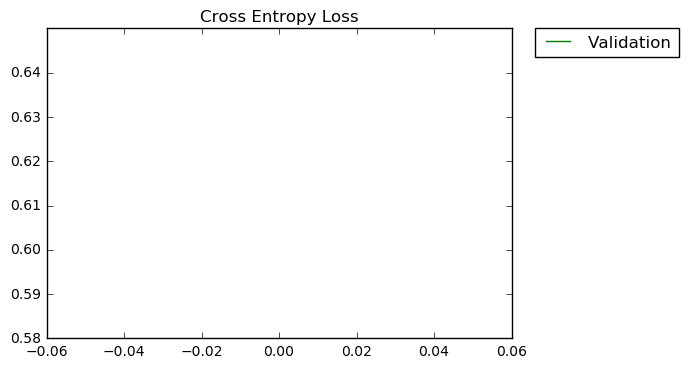

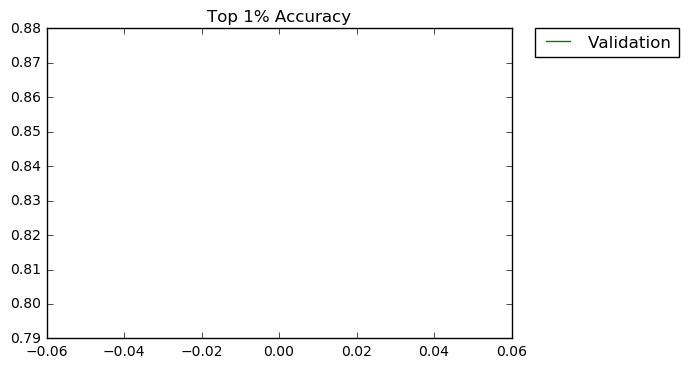

requesting stop


In [3]:
train_loss_list, train_accuracy_list, plot_train_loss, plot_train_accuracy,l2_loss_list, plot_l2_loss =  [], [], [], [], [], []
val_loss_list , val_accuracy_list ,plot_val_loss, plot_val_accuracy,val_top5_list = [], [], [], [], []

try:   
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        epoch_start_time = time.time()
        
        print((19201/ BATCH_SIZE))
        for i in xrange(((19201 / BATCH_SIZE))+1):
            val_loss, val_accuracy, val_top5,confusion_matrix = sess.run(
               [loss_tf, accuracy,accuracy_top5,confusion],feed_dict={train_mode: False})

            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            val_top5_list.append(val_top5)
            sys.stdout.write('\r\r' + "Iteration:" + str(i)+ "  Loss: "+ str(val_loss))
            sys.stdout.flush()
        
        
        val_loss_mean = np.mean(val_loss_list)
        val_accuracy_mean = np.mean(val_accuracy_list)
        val_top5_mean = np.mean(val_top5_list)
        
        
        plot_val_loss.append(val_loss_mean)
        plot_val_accuracy.append(val_accuracy_mean)
      
        val_loss_list = []
        val_accuracy_list = []
        val_top5_list =[]
                
            

        clear_output()
        #print "===========**Training ACCURACY**================"
        #print "Epoch:", epoch
        #print 'Training Accuracy: ', train_accuracy_mean       
        #print "Training Loss:", train_loss_mean 
        #print "L2 Loss:", l2_loss_mean
        print confusion_matrix[1]
        print "===========**VALIDATION ACCURACY**================"
        print 'Epoch:', epoch
        print 'Validation Top5: ', val_top5_mean
        print 'Validation Accuracy: ', val_accuracy_mean
        print "Validation Loss:", val_loss_mean
        
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'

        #plt.figure(1) 
        #aa = plt.plot(plot_l2_loss,'r')
        #plt.title("L2 LOSS")
        plt.figure(1) 
        #aa = plt.plot(plot_train_loss,'r',label="Training")
        bb = plt.plot(plot_val_loss,'g',label="Validation")
        plt.title("Cross Entropy Loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(2)
        #cc = plt.plot(plot_train_accuracy,'r',label="Training")
        dd = plt.plot(plot_val_accuracy,'g',label="Validation")
        plt.title("Top 1% Accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

        
        #saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
        #vgg.save_npy(sess, '/mnt/data1/imagenet-data/weights/vgg-epoch-' + str(epoch) + '.npy')
        ofile  = open('pre_val.csv', "a")
        writer = csv.writer(ofile)
        timep=((time.time() - epoch_start_time) / 60.)
        writer.writerow([timep,val_loss_mean,val_accuracy_mean,val_top5_mean,epoch])
        ofile.close()
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")

In [4]:
cm=confusion_matrix[1]
recall_div=np.sum(cm,axis=0)
percision_div=np.sum(cm,axis=1)
recall=[0 for x in range(1000)]
percision=[0 for x in range(1000)]

#for i in xrange(len(cm[0])):
#    recall[i]=(cm[i][i]/recall_div[i])
#    percision[i]=(cm[i][i]/percision_div[i])
#print recall
#print np.sort(recall)
ofile  = open('confusion_coarse.csv', "w")
writer = csv.writer(ofile)
num=0
for i in range(len(confusion_matrix[1][1])):
    writer.writerow(confusion_matrix[1][i])
    num+=1
    
print(num)
ofile.close()

24


In [ ]:
print len(confusion_matrix[1])